# Board Game Recommender

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output

%matplotlib inline

In [2]:
def politerequest(url, delay=1):
    """This function tries to get a webpage.
    If the request returns a status code 429 Too Many Requests, the program waits before the next attempt"""
    
    # make a request to the url and then wait
    r = requests.get(url)
    time.sleep(delay)
    
    # wait longer if server returns status 429 for too many requests or 5xx for server error
    while (r.status_code == 429) | (r.status_code >= 500):
        waittime = 30
        display('Too many attempts. Waiting ' + str(waittime) + ' seconds.')
        clear_output(wait=True)
        time.sleep(waittime)
        r = requests.get(game_url)
    return r

In [41]:
# base url to find board game rankings and IDs
base_url = 'https://boardgamegeek.com/browse/boardgame/page/'
game_dict = {}

# page to start on
page = 70

# set number of games to scrape info on, games will be chosen and ordered by popularity
gamecount = 1000

#while len(game_dict)%100 == 0:
while len(game_dict) < gamecount:
    
    # make request and display current page on BGG; site loads 100 games per page
    r = politerequest(base_url + str(page),0.25)
    clear_output(wait=True)
    display('Current page: ' + str(page))
    
    # iterate page
    page += 1
    
    # load page html and parse out game name, rank, ID number, and number of voter
    soup = BeautifulSoup(r.content, 'lxml')
    games = soup.find_all('div', id = re.compile('results_objectname.+?'))
    ranks = soup.find_all('td', class_ = 'collection_rank')
    nums_votersoup = soup.find_all('td', class_ = 'collection_bggrating')[2::3]
    
    # create dictionary from scraped information
    for rank, game, num_votersoup in zip(ranks, games, nums_votersoup):
        try:
            rank_num = rank.a.get('name')
        except:
            rank_num = None
        if rank_num is not None:
            game_id = re.search('boardgame(expansion)*/(.+?)/', str(game)).group(2)
            game_name = game.a.get_text()
            game_rank = rank_num
            num_voters = int(num_votersoup.text)
            game_dict[game_id] = {'name': game_name, 'rank': game_rank, 'num_voters': num_voters}

#update display when finished
clear_output(wait=True)
display('Done gathering ' + str(len(game_dict)) + ' game IDs, names, and rankings.')

'Done gathering 1096 game IDs, names, and rankings.'

In [42]:
def chunks(l, n):
    '''Iterator function to group together game IDs to reduce API requests'''
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

# number of game IDs to group
chunksize = 25

# sort IDs by number of votes to minimize number of requests to API
rank_df = pd.DataFrame.from_dict(game_dict, orient = 'index')
rank_df = rank_df.sort_values('num_voters', ascending = False)

# call chunks to group IDs
id_blocks = list(chunks(list(rank_df.index), chunksize))

# join lists of IDs into strings for API requests
id_block_str = []
for id_block in id_blocks:
    id_block_str.append(','.join(id_block))

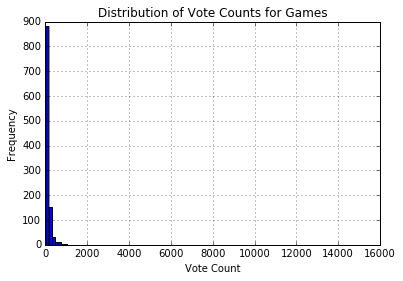

Gathering data for these 1096 games will take about 214 requests


In [43]:
# plot histogram of game vote counts
rank_df.hist('num_voters',bins=100)
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Distribution of Vote Counts for Games')
plt.show()

# calculate how many API requests to get an idea of time
vote_counts = list(rank_df.num_voters)[::chunksize]
totalpages = 0
for vote_count in vote_counts:
    totalpages += vote_count//100+1
print 'Gathering data for these '+str(len(game_dict))+' games will take about '+str(totalpages)+' requests'

In [44]:
for index, id_block in enumerate(id_block_str,1):
    # load first page and parse out actual number of comments to determine how many pages of information to request for this block of games
    # 100 comments per page
    game_url = 'https://boardgamegeek.com/xmlapi2/thing?id='+id_block+'&stats=1&ratingcomments=1&page=1'
    r = politerequest(game_url, 1)
    soup = BeautifulSoup(r.content, 'lxml-xml')
    itemssoup = soup.findAll('item')
    ncommentpages = int(soup.find('comments')['totalitems'])//100+1
    
    for page in range(1,ncommentpages+1):
        # display progress
        clear_output(wait=True)
        display('Parsing page '+str(page)+' of '+str(ncommentpages)+' in block '+str(index)+' of '+str(len(id_block_str)))
        
        if page == 1:
            # gather and store important game information on the first page
            for itemsoup in itemssoup:
                id = itemsoup['id']

                attributes = {}
                attributesoup = itemsoup.findAll('link')
                for attribute in attributesoup:
                    attributes[attribute['type']] = attribute['value']

                ratings = {}
                commentsoup = itemsoup.findAll('comment')
                for comment in commentsoup:
                    ratings[comment['username']] = comment['rating']

                player_count = {}
                countsoup = itemsoup.findAll('results', numplayers = re.compile(''))
                for count in countsoup:
                    resultsoup = count.findAll('result')
                    vote_count = {}
                    for result in resultsoup:
                        vote_count[result['value']] = result['numvotes']
                    player_count[count['numplayers']] = vote_count
                
                average_rating = itemsoup.average['value']
                weighted_rating = itemsoup.bayesaverage['value']
                play_time = itemsoup.playingtime['value']
                weight = itemsoup.averageweight['value']
                description = itemsoup.description.text
                year = itemsoup.yearpublished['value']
                
                game_dict[id].update({'average_rating':average_rating, 'weighted_rating':weighted_rating, 'description':description,
                                    'attributes': attributes, 'player_count': player_count, 'play_time':play_time, 'year':year,
                                    'weight':weight, 'ratings':ratings})

        else:
            # if there is more than 1 page, load them 1 at a time
            game_url = 'https://boardgamegeek.com/xmlapi2/thing?id='+id_block+'&stats=1&ratingcomments=1&page='+str(page)
            r = politerequest(game_url, 1)
            soup = BeautifulSoup(r.content, 'lxml-xml')
            itemssoup = soup.findAll('item')
            
            # gather and store game ratings from current page
            for itemsoup in itemssoup:
                id = itemsoup['id']
                commentsoup = itemsoup.findAll('comment')
                for comment in commentsoup:
                    game_dict[id]['ratings'][comment['username']] = comment['rating']
        
        for itemsoup in itemssoup:
                id = itemsoup['id']
                game_dict[id]['last_updated'] = time.ctime()
        
clear_output(wait=True)
display('Done')

'Done'

In [48]:
game_df = pd.DataFrame.from_dict(game_dict, orient = 'index')
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 10022 to 99976
Data columns (total 13 columns):
ratings            1096 non-null object
last_updated       1096 non-null object
player_count       1096 non-null object
num_voters         1096 non-null int64
name               1096 non-null object
weight             1096 non-null object
rank               1096 non-null object
average_rating     1096 non-null object
year               1096 non-null object
attributes         1096 non-null object
play_time          1096 non-null object
weighted_rating    1096 non-null object
description        1096 non-null object
dtypes: int64(1), object(12)
memory usage: 119.9+ KB


In [51]:
#game_df.to_json('bgg_database.json')
game_df

,ratings,last_updated,player_count,num_voters,name,weight,rank,average_rating,year,attributes,play_time,weighted_rating,description
10022,"{u'marticabre': u'8', u'Chimes': u'7', u'Charl...",Mon Jan 28 15:48:05 2019,"{u'6+': {u'Recommended': u'0', u'Not Recommend...",59,La Révolution française: La patrie en danger 1...,3.6,7608,7.11017,1995,"{u'boardgamedesigner': u'Lionel Ruelle', u'boa...",180,5.56959,(from the rulebook:)&#10;&#10;The game starts ...
101118,"{u'petermc': u'7.5', u'Datonnedlock': u'8', u'...",Mon Jan 28 15:47:59 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",63,Borodino: Napoleon in Russia 1812,2.2222,7657,7.09683,2012,"{u'boardgamedesigner': u'Carl Willner', u'boar...",210,5.56873,Summary from Columbia Games website:&#10;&#10;...
101206,"{u'marticabre': u'8', u'jjrbedford': u'8', u'Z...",Mon Jan 28 15:48:14 2019,"{u'1': {u'Recommended': u'3', u'Not Recommende...",53,Night Drop: 6 June 44,2.3,7183,7.34057,2012,"{u'boardgamedesigner': u'Laurent Closier', u'b...",180,5.57852,"During the night of 5-6 june 1944, the 82nd an..."
101644,"{u'dghughes': u'4', u'Boofus': u'7', u'Kihon':...",Mon Jan 28 15:48:14 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",52,Bushido,3.375,7433,8.28846,2011,"{u'boardgamedesigner': u'Toby Nathan', u'board...",90,5.57323,From the Developer's Website:&#10;&#10;Bushido...
10168,"{u'davekaz53': u'5', u'ainataqe': u'6', u'zelv...",Mon Jan 28 15:48:09 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",57,Citadel: The Battle of Dien Bien Phu,3.1,7208,7.74912,1977,"{u'boardgamedesigner': u'Frank Chadwick', u'bo...",360,5.57808,Citadel is a two-player game of the battle of ...
10186,"{u'Fr33man': u'7', u'JSLM': u'8', u'Charles Va...",Mon Jan 28 15:47:23 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",96,JENA!,2.8421,6982,6.79583,1996,"{u'boardgamedesigner': u'Ed Wimble', u'boardga...",300,5.58298,Discern the Secrets of Napoleon's Greatest Man...
101930,"{u'BosonMichael': u'7', u'levzilla': u'6', u'H...",Mon Jan 28 15:45:06 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",487,Carnival,1.5152,7397,5.76815,2011,{u'boardgamedesigner': u'Cherilyn Joy Lee Kirk...,30,5.57393,"Think Ferris wheels, roller-coasters, carousel..."
102219,"{u'mulderman': u'9', u'wizpop': u'6.4', u'Flor...",Mon Jan 28 15:46:43 2019,"{u'0+': {u'Recommended': u'0', u'Not Recommend...",125,Connect 4 Launchers,1,7716,6.24328,2011,"{u'boardgamedesigner': u'Craig Van Ness', u'bo...",0,5.56759,Launch it to win! Grab you launcher and send y...
10234,"{u'thekossack': u'7', u'Charles Vasey': u'5', ...",Mon Jan 28 15:47:13 2019,"{u'1': {u'Recommended': u'2', u'Not Recommende...",104,¡Arriba España!,2.7895,7532,6.46529,1997,"{u'boardgamedesigner': u'Brian Train', u'board...",120,5.57105,From the box of Third Edition:&#10;&#10;&iexcl...
10245,"{u'avdtweel': u'9.7', u'Frechdax': u'1', u'par...",Mon Jan 28 15:48:25 2019,"{u'1': {u'Recommended': u'1', u'Not Recommende...",42,Bloody Omaha: D-Day 1944,4.6364,7369,7.90952,2009,"{u'boardgamedesigner': u'Ray Tapio', u'boardga...",180,5.57449,BLOODY OMAHA: D-DAY 1944 is a detailed new Adv...
